In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/datathon-advanced-level/sample_submission.csv
/kaggle/input/datathon-advanced-level/train.csv
/kaggle/input/datathon-advanced-level/test.csv


In [2]:
import pandas as pd

train = pd.read_csv("../input/datathon-advanced-level/train.csv")
test = pd.read_csv("../input/datathon-advanced-level/test.csv")

In [3]:
train.head()

,Date,Store,Item,Sales,Average Rating,Location,Category,Branding
0,2013-01-01,1,1,13,2.8,Wheelers Hill VIC 3170,Electronics,Sony
1,2013-01-02,1,1,11,1.4,Wheelers Hill VIC 3170,Electronics,Sony
2,2013-01-03,1,1,14,1.8,Wheelers Hill VIC 3170,Electronics,Sony
3,2013-01-04,1,1,13,1.3,Wheelers Hill VIC 3170,Electronics,Sony
4,2013-01-05,1,1,10,2.9,Wheelers Hill VIC 3170,Electronics,Sony


In [4]:
test.head()

,Date,Store,Item,Sales,Average Rating,Location,Category,Branding
0,2017-07-01,1,1,31,1.5,Wheelers Hill VIC 3170,Electronics,Sony
1,2017-07-02,1,1,38,1.8,Wheelers Hill VIC 3170,Electronics,Sony
2,2017-07-03,1,1,18,2.1,Wheelers Hill VIC 3170,Electronics,Sony
3,2017-07-04,1,1,23,2.5,Wheelers Hill VIC 3170,Electronics,Sony
4,2017-07-05,1,1,23,1.4,Wheelers Hill VIC 3170,Electronics,Sony


In [5]:
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [6]:
train['rolling_feature'] = train['Sales'].rolling(window=7).mean()
test['rolling_feature'] = test['Sales'].rolling(window=7).mean()

In [7]:
train.loc[train.rolling_feature.isna(),'rolling_feature'] = train.loc[:10,"rolling_feature"].mean()
test.loc[test.rolling_feature.isna(),'rolling_feature'] = test.loc[:10,"rolling_feature"].mean()

In [8]:
train['year']=train['Date'].dt.year 
train['month']=train['Date'].dt.month 
train['day']=train['Date'].dt.day

test['year']=test['Date'].dt.year 
test['month']=test['Date'].dt.month 
test['day']=test['Date'].dt.day

In [9]:
from sklearn.model_selection import train_test_split


X = train.loc[:,["Store","Item","month","day","year","rolling_feature"]]
X_test = test.loc[:,["Store","Item","month","day","year","rolling_feature"]]
y = train.Sales
y_test = test.Sales

X_train,X_valid,y_train,y_valid = train_test_split(X,y,test_size = 0.3, shuffle = False)

In [10]:
# from lightgbm import LGBMRegressor

# model = LGBMRegressor()
# model.fit(X_train,y_train)

In [11]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

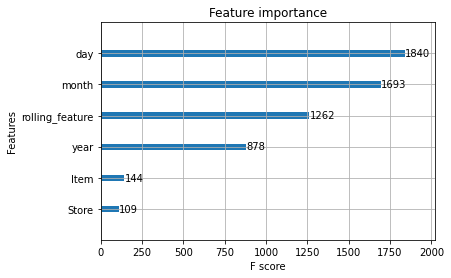

In [12]:
from xgboost import plot_importance

plot_importance(model)

In [13]:
import numpy as np

def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))


print(smape(pd.Series(model.predict(X_valid),index=y_valid.index),y_valid))

14.276835981239103


In [14]:
sample_solution = pd.DataFrame(pd.Series(model.predict(X_test),index=y_test.index)).reset_index()
sample_solution.columns = ['ID','Sales']
sample_solution.to_csv("./sample_solution.csv", index = False)